In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import sys
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import h5py
sys.path.append('../../../src/')

import fastmri
from fastmri.data.subsample import EquispacedMaskFunc
from fastmri.data import transforms as T

# custom scripts
import mri_cs
from visualization import plot_batch
from helpers import calculate_metrics, zero_fill
from spiraltrajectory import spiral_samples_trajectory, kspace_measurements_spiral, minimum_energy_reconstruction
# from mri_cs import lpminimization, hermitian

from tqdm import tqdm
from matplotlib.colors import LogNorm
from numpy.fft import fft2, fftshift
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams['figure.figsize'] = (10.0, 8.0)
py.init_notebook_mode()
plt.style.use('dark_background')
layout = go.Layout(template="ggplot2")
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [2]:
DATA_PATH = '../../../data/FastMRIData/singlecoil_train/'
FILE_SAMPLE = DATA_PATH + 'file1001287.h5'

hf = h5py.File(FILE_SAMPLE, mode='r')
list(hf.keys())
dict(hf.attrs)

['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']

{'acquisition': 'CORPD_FBK',
 'max': 0.0004624860345092124,
 'norm': 0.1396935333699368,
 'patient_id': '6999a1ffb63756b29125b8779ce2c956620ff82c62700fe687d4a0d823b066b8'}

# Images to be reconstructed

(640, 372)

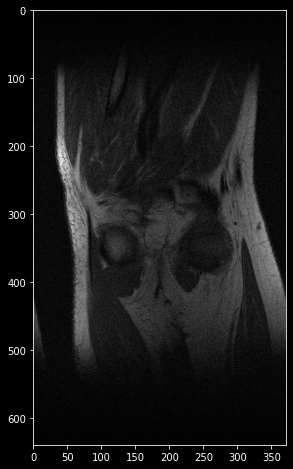

In [3]:
slice_kspace = hf["kspace"][()][-5]
rows, cols = slice_kspace.shape
rows, cols
slice_kspace = T.to_tensor(slice_kspace)

fully_sampled = fastmri.complex_abs(fastmri.ifft2c(slice_kspace))
_ = plt.imshow(fully_sampled, cmap="gray")

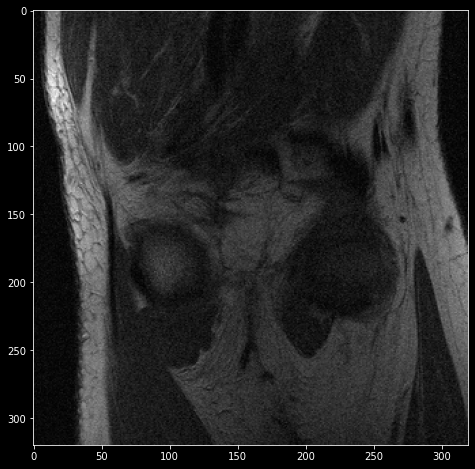

In [4]:
cropped_fully = T.center_crop(fully_sampled, (320, 320))
_ = plt.imshow(cropped_fully, cmap="gray")

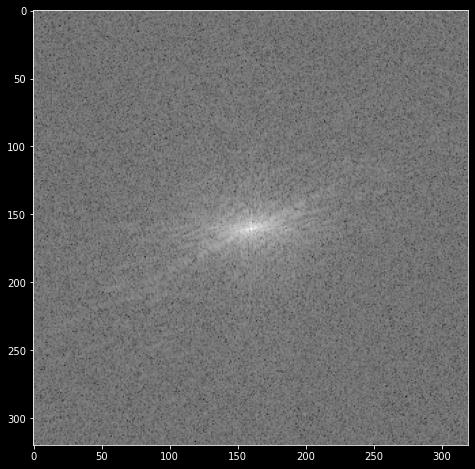

In [38]:
from fastmri import complex_abs

cropped_kspace = T.complex_center_crop(slice_kspace, (320, 320))
_ = plt.imshow(np.log(complex_abs(cropped_kspace)), cmap="gray")

# K-space Trajectory

In [45]:
slice_kspace = cropped_kspace
fully_sampled = cropped_fully
rows, cols = cropped_fully.shape

torch.Size([320, 320, 2])

<ipython-input-46-f899f6914470>:4: RuntimeWarning:

divide by zero encountered in log



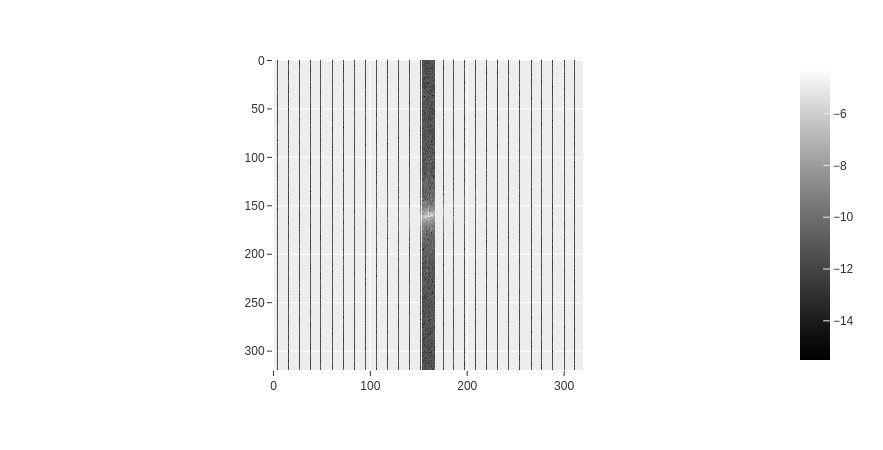

In [46]:
mask_func = EquispacedMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object
masked_kspace, mask = T.apply_mask(slice_kspace, mask_func)   # Apply the mask to k-space
masked_kspace.shape
px.imshow(np.log(fastmri.complex_abs(masked_kspace)), color_continuous_scale="gray")

# Zero filled

PSNR: 132.78422710500175
SSIM: 0.9999921954650456
SNR: 1.9127245247364044
MSE: 3.4249769288591062e-09


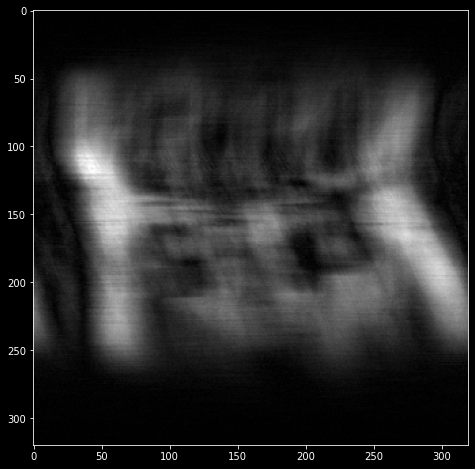

In [47]:
masked_img = fastmri.complex_abs(fastmri.ifft2c(masked_kspace))
_ = plt.imshow(masked_img, cmap="gray")
_ = calculate_metrics(fully_sampled.numpy(), masked_img.numpy())

In [48]:
T.tensor_to_complex_np(masked_kspace)
samples_rows = np.where(T.tensor_to_complex_np(masked_kspace).flatten() != 0)[0]

samples_rows.size / T.tensor_to_complex_np(masked_kspace).size
samples_rows.shape
samples_rows

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

0.125

(12800,)

array([     4,     15,     27, ..., 102368, 102380, 102391])

# Measurements from the image to be reconstructed

In [49]:
stacked_kspace_hat = T.tensor_to_complex_np(slice_kspace).flatten()
stacked_kspace_hat.shape

# measurements to be used
b = stacked_kspace_hat[samples_rows]
b.size
b

b.size / stacked_kspace_hat.size

(102400,)

12800

array([ 4.6313962e-06-5.8788050e-06j, -3.1059308e-06+4.8643278e-06j,
       -1.2434353e-05+6.1291566e-06j, ...,  6.1341248e-06-5.1033282e-08j,
        1.9896395e-06-1.0661125e-05j, -8.9396044e-06+7.6318120e-06j],
      dtype=complex64)

0.125

# Image reconstruction

In [50]:
# reconstrucao do sinal a partir das medidas
A_ = lambda x: np.fft.fft2(np.reshape(x, (rows, cols))).flatten()[samples_rows]
img_size = rows * cols

# transposta conjugada
def a(x):
    a = np.reshape(x, (rows, cols))
    a = np.fft.fft2(a)
    a = a.flatten()[samples_rows]
    return a

def ah(x):
    x = fill_with_zeros(x, samples_rows, rows, cols)
    x = np.fft.ifft2(x)
    x = x * (rows * cols)
    x = x.flatten()
    return x

def fill_with_zeros(x, samples_rows, rows, cols):
    y = np.zeros((rows * cols)) * 1j

    y[samples_rows] = x
    y = np.reshape(y, (rows, cols))
    return y

In [51]:
b.size
samples_rows.shape
rows * cols
img_size * img_size

12800

(12800,)

102400

10485760000

In [52]:
import importlib
importlib.reload(mri_cs)
maxiterperstage = 50
tol = 1e-5

img_hat_r = mri_cs.lpminimization(A_, Ah=ah, b=b, p=1, N=(rows * cols), verbose=True, tol_cg=tol, maxiterperstage=maxiterperstage)

<module 'mri_cs' from '../../../src/mri_cs.py'>

{'A_': <function <lambda> at 0x7f7ff4c83c10>, 'Ah': <function ah at 0x7f7ff4c83550>, 'b': array([ 4.6313962e-06-5.8788050e-06j, -3.1059308e-06+4.8643278e-06j,
       -1.2434353e-05+6.1291566e-06j, ...,  6.1341248e-06-5.1033282e-08j,
        1.9896395e-06-1.0661125e-05j, -8.9396044e-06+7.6318120e-06j],
      dtype=complex64), 'p': 1, 'initial_mu': 1.0, 'mu_reduction_function': <function <lambda> at 0x7f7ff5246160>, 'min_mu': 1e-08, 'x0': array([], dtype=float64), 'N': 102400, 'maxiterperstage': 50, 'maxiter_cg': [], 'tol_cg': 1e-05, 'information_string': '', 'phi': [], 'tau': 0.1, 'verbose': True, 'custom_cg': <function lgmres at 0x7f8054a87af0>}
Starting stage 1
    Iteration 1
Starting stage 2
    Iteration 1
Starting stage 3
    Iteration 1
Starting stage 4
    Iteration 1
Starting stage 5
    Iteration 1
Starting stage 6
    Iteration 1
Starting stage 7
    Iteration 1
Starting stage 8
    Iteration 1
    Iteration 2
Starting stage 9
    Iteration 1
    Iteration 2
    Iteration 3
 

PSNR: 130.88870345620154
SSIM: 0.999987251421256
SNR: 0.017200864690772782
MSE: 5.29919639409556e-09


../../../src/helpers.py:43: UserWarning:

Inputs have mismatched dtype.  Setting data_range based on im1.dtype.



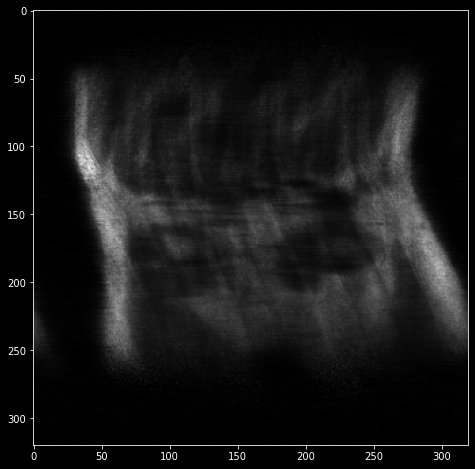

In [53]:
img_r = np.abs(np.fft.ifftshift(np.reshape(img_hat_r, (rows, cols))))
_ = plt.imshow(img_r, cmap='gray')
_ = calculate_metrics(fully_sampled.numpy(), img_r)

In [32]:
filter1 = np.array([[1, 1], [-1, -1]])
filter2 = filter1.copy().T
filter3 = np.array([[1, -1], [-1, 1]])

initial_filters = [filter1, filter2, filter3]
# plt.imshow(filter3, cmap="gray");

In [33]:
from importlib import reload
reload(mri_cs)

prefilter_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, p=1, 
                                      h=initial_filters, tol_cg=tol, maxiterperstage=maxiterperstage, verbose=True)


<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
{'A_': <function prefiltering.<locals>.A at 0x7f7ff4d20d30>, 'Ah': <function prefiltering.<locals>.Ah at 0x7f7ff4d39e50>, 'b': array([ 3.57351807e-06+2.35460556e-06j,  4.90711749e-06-4.57667112e-06j,
        4.84713156e-06+9.09671627e-06j, ...,
       -2.07966171e-06-7.90400819e-06j, -4.41136510e-06-1.25209851e-06j,
       -2.82599983e-07-4.22916551e-06j]), 'p': 1, 'initial_mu': 1.0, 'mu_reduction_function': <function <lambda> at 0x7f80001c9f70>, 'min_mu': 1e-08, 'x0': array([], dtype=float64), 'N': 238080, 'maxiterperstage': 50, 'maxiter_cg': [], 'tol_cg': 1e-05, 'information_string': ' image 1 of 3', 'phi': array([], dtype=float64), 'tau': 0.1, 'verbose': True, 'custom_cg': <function lgmres at 0x7f8054a87af0>}


KeyboardInterrupt: 

# Compressed Sensing with Pre-filtering

PSNR: 133.69673381943815
SSIM: 0.9999933041522066
SNR: 0.00842739415524294
MSE: 2.775920211010608e-09


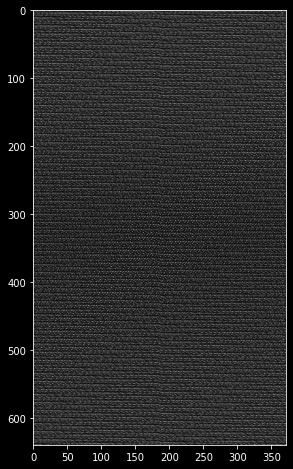

In [26]:
prefilter_recon_img = np.abs(np.fft.ifftshift(np.reshape(prefilter_recon, (rows, cols))))
_ = plt.imshow(prefilter_recon_img, cmap="gray")
_ = calculate_metrics(fully_sampled.numpy(), prefilter_recon_img)